# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import torch
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt = os.path.join(MODEL_PATH, "SIR_stockflow.json")

### Set parameters for sampling

In [13]:
start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 100

### Define QoI function

In [4]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [15]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor([x])],
    start_time = intervention_time,
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=int(1e2),
    maxiter=0,
    maxfeval=20,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

#### Sample using optimal policy as intervention

In [24]:
result1 = pyciemss.sample(
    model_opt,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="euler",
)
display(result1["data"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

{1.0: {'p_cbeta': tensor([0.2237])}}


,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.314054,19.060932,1.261276,0.052463,999.686279
1,1,0,2.0,0.314054,19.060932,1.476883,0.118634,999.404480
2,2,0,3.0,0.314054,19.060932,1.729253,0.196116,999.074646
3,3,0,4.0,0.314054,19.060932,2.024620,0.286839,998.688538
4,4,0,5.0,0.314054,19.060932,2.370264,0.393057,998.236694
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.390894,9.445127,48.182121,46.284496,906.533569
3896,35,99,36.0,0.390894,9.445127,52.842022,51.385765,896.772400
3897,36,99,37.0,0.390894,9.445127,57.837330,56.980400,886.182434
3898,37,99,38.0,0.390894,9.445127,63.167980,63.103909,874.728271


## Optimize interface for optimizing start time

In [32]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 1.
bounds_interventions = [[0.5], [39.5]]
intervention_value = [0.15]
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor(intervention_value),
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=10,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)











6it [00:46,  7.75s/it]

Optimal policy: tensor([4.], dtype=torch.float64)
{'policy': tensor([4.], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -4.0
                          x: [ 4.000e+00]
                        nit: 1
      minimization_failures: 2
                       nfev: 4
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -4.0
                                   x: [ 4.000e+00]
                                nfev: 2
                               maxcv: 0.0}


In [33]:
result2 = pyciemss.sample(
    model_opt,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
)
display(result2["data"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.349256,12.813910,1.270867,0.078040,999.651123
1,1,0,2.0,0.349256,12.813910,1.614947,0.177219,999.207886
2,2,0,3.0,0.349256,12.813910,2.051936,0.303250,998.644836
3,3,0,4.0,0.349256,12.813910,2.606766,0.463383,997.929871
4,4,0,5.0,0.349256,12.813910,2.232644,0.474755,998.292603
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.313551,17.372927,29.385365,17.954084,953.660400
3896,35,99,36.0,0.313551,17.372927,31.893269,19.645531,949.461060
3897,36,99,37.0,0.313551,17.372927,34.595139,21.481333,944.923401
3898,37,99,38.0,0.313551,17.372927,37.502380,23.472658,940.024841


## Optimize for start times of multiple interventions

In [7]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta", "p_tr"]
initial_guess_interventions = [5., 5.]
bounds_interventions = [[5., 5.], [39., 39.]]
intervention_value = [0.15, 15]
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor(intervention_value),
)

risk_bound = 300.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=int(1e2),
    maxiter=1,
    maxfeval=10,
    solver_method="euler",
)
print(f'Optimal policy:', opt_result3["policy"])
print(opt_result3)


22it [04:42, 12.85s/it]

Optimal policy: tensor([33.4822, 33.7300], dtype=torch.float64)
{'policy': tensor([33.4822, 33.7300], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -67.21213438451318
                          x: [ 3.348e+01  3.373e+01]
                        nit: 1
      minimization_failures: 2
                       nfev: 20
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: -67.21213438451318
                                   x: [ 3.348e+01  3.373e+01]
                                nfev: 10
                               maxcv: 0.0}


In [8]:
static_parameter_interventions(opt_result3["policy"])

{33.4822: {'p_cbeta': tensor(0.1500)}, 33.73: {'p_tr': tensor(15.)}}

,timepoint_id,sample_id,timepoint_unknown,persistent_p_cbeta_param,persistent_p_tr_param,I_state,R_state,S_state
0,0,0,1.0,0.35456,11.787394,1.269370,0.084836,999.645813
1,1,0,2.0,0.35456,11.787394,1.611140,0.192525,999.196350
2,2,0,3.0,0.35456,11.787394,2.044674,0.329208,998.626160
3,3,0,4.0,0.35456,11.787394,2.594452,0.502671,997.902893
4,4,0,5.0,0.35456,11.787394,3.291391,0.722775,996.985840
...,...,...,...,...,...,...,...,...
3895,34,99,35.0,0.15000,15.000000,12.548655,2.891558,985.559875
3896,35,99,36.0,0.15000,15.000000,13.565342,3.728135,983.706604
3897,36,99,37.0,0.15000,15.000000,14.660634,4.632492,981.706970
3898,37,99,38.0,0.15000,15.000000,15.839969,5.609867,979.550232


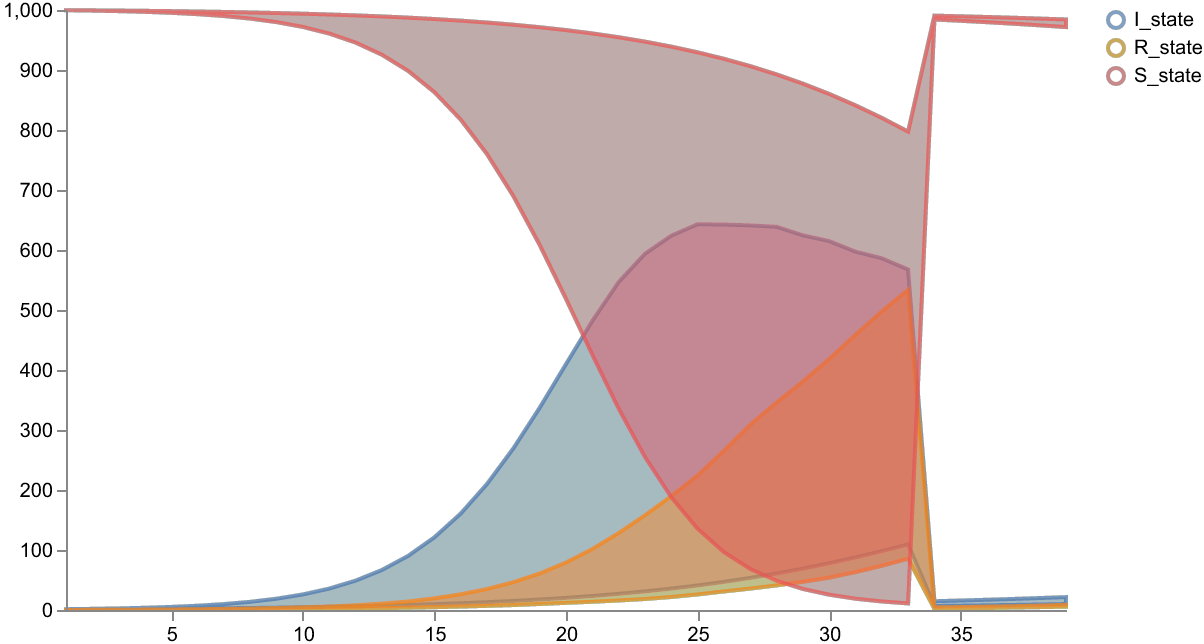

In [14]:
result3 = pyciemss.sample(
    model_opt,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
    solver_method="euler",
)
display(result3["data"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep=".*_state")
plots.ipy_display(schema, dpi=150)